# Green Networking - Demo Application

**Visibility, a first step towards sustainable networking.**

---

### Important Terms and Abbreviations
- **Hop Efficiency Indicator (HEI):** Each hop on a network path calculates a value composed of an arbitrary number of raw components. These components include but are not limited to idle power, energy mix, embedded carbon and link cost. All these raw component values are normalized and aggregated by sum operation to the HEI. A hop with a low HEI value is considered more energy efficient.

- **Path Efficiency Indicator (PEI):** The path efficiency indicator is an aggregation by sum operation with all HEI values on a path. This value indicates the efficiency of the path the packet traversed.

## Topology
The demo application is based on the network topology as described in the project documenation in the chapter Development Environment.
The following paths are used in the demo application and will be further named Path 1 and Path 2.  

**Path 1:** H1 - S1 - S2 - S4 - H2  
**Path 2:** H1 - S1 - S3 - S4 - H3

![Development Network](figures/development_network.png)

In [1]:
import json
import os

## Helper Constants
BASE_DEMO_PATH = '../demo/'
BASE_RUNTIME_PATH = '../tmp_runtimes/'
IOAM_SUM_AGGREGATE = 1
IOAM_MIN_AGGREGATE = 2
IOAM_MAX_AGGREGATE = 4

PATH_EXPORT_FILES = {
    1 : os.path.join(BASE_DEMO_PATH, "h2.json"),
    2 : os.path.join(BASE_DEMO_PATH, "h3.json")
}

HOST_NAME_TO_PATH = {
    "h2": 1,
    "h3": 2,
}

## Helper Functions

def get_all_packets(packet_export_file):
    with open(packet_export_file, "r") as f:
        packets = json.load(f)
    return packets

def filter_packets_by_aggregate(packets, aggregate):
    packet_list = []
    for packet in packets:
        if packet["hop_by_hop_option"]["ioam_option_aggregation"]["aggregator"] == aggregate:
            packet_list.append(packet)
    return packet_list

def get_min_hei(packets):
    hei_min = packets[0]["hop_by_hop_option"]["ioam_option_aggregation"]["aggregate"]
    node_id = packets[0]["hop_by_hop_option"]["ioam_option_aggregation"]["auxil_data_node_id"]
    for packet in packets:
        paket_hei = packet["hop_by_hop_option"]["ioam_option_aggregation"]["aggregate"]
        if paket_hei < hei_min:
            hei_min = paket_hei
            node_id = packet["hop_by_hop_option"]["ioam_option_aggregation"]["auxil_data_node_id"]
    return (hei_min, node_id)


def get_max_hei(packets):
    hei_max = packets[0]["hop_by_hop_option"]["ioam_option_aggregation"]["aggregate"]
    node_id = packets[0]["hop_by_hop_option"]["ioam_option_aggregation"]["auxil_data_node_id"]
    for packet in packets:
        paket_hei = packet["hop_by_hop_option"]["ioam_option_aggregation"]["aggregate"]
        if paket_hei > hei_max:
            hei_max = paket_hei
            node_id = packet["hop_by_hop_option"]["ioam_option_aggregation"]["auxil_data_node_id"]
    return (hei_max, node_id)

## Timeseries per path
In the first demonstration the default runtime configuration is initially loaded and five packets will be sent over path 1.
For each demo case listed below, five packets will be sent with a different energy mix parameter value.
After all packets are sent via path 1 the same amount of packets with the same energy mix values are sent over path 2.

The visualizations shows a simulated day where the sustainable energy generated by solar power fluctuates:  

Packet 0-4: Demo with the default energy mix value on each node.  
Packet 5-9: Demo with energy mix value in the morning, set value to 30.  
Packet 10-14: Demo with energy mix value at lunch time, set value to 90.  
Packet 15-19: Demo with energy mix value in the afternoon, set value to 65.  
Packet 20-24: Demo with energy mix value in the evening, set value to 15.  

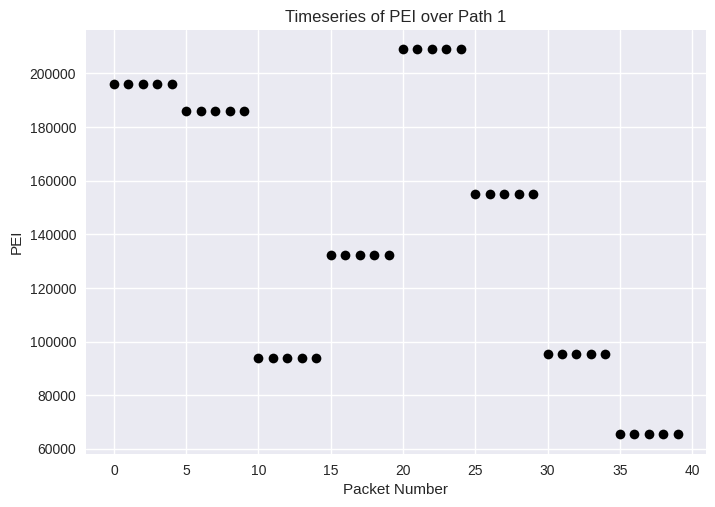

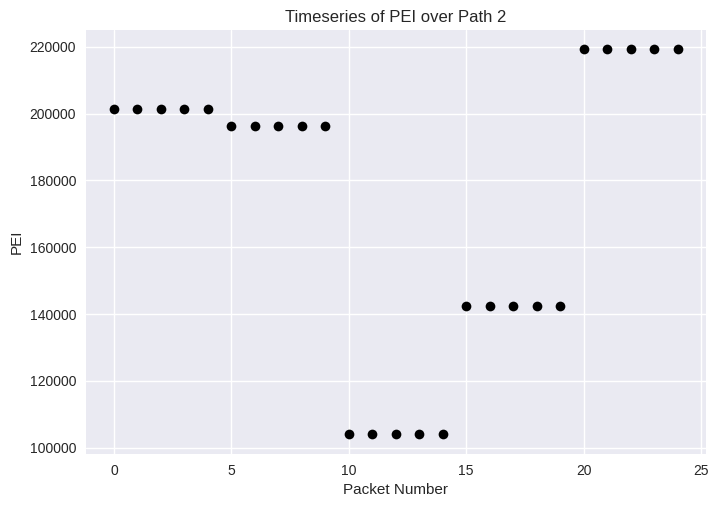

In [4]:
import json
import os
from matplotlib import pyplot as plt

# Datastructure to store packets per path
receiving_hosts = {
    "h2": None,
    "h3": None
    }

def set_export_data(host):
    export_file = os.path.join(BASE_DEMO_PATH, f"{host}.json")
    with open(export_file, "r") as file:
        data = json.load(file)
    receiving_hosts[host] = data

def get_plot_data(host):
    plot_data = {
        "aggregate": []
    }
    
    PATH_ID = HOST_NAME_TO_PATH[host]
    packets = filter_packets_by_aggregate(get_all_packets(PATH_EXPORT_FILES[PATH_ID]), IOAM_SUM_AGGREGATE)
    
    for packet in packets:
        plot_data["aggregate"].append(packet["hop_by_hop_option"]["ioam_option_aggregation"]["aggregate"])
    return plot_data, packets

def plot_path_timeseries(host):
    
    plot_data, packets = get_plot_data(host)
    x = list(range(0,len(packets)))

    plt.style.use('seaborn')
    plt.title('Timeseries of PEI over Path ' + str(HOST_NAME_TO_PATH[host]))
    plt.ylabel('PEI')
    plt.xlabel('Packet Number')
    plt.plot(x, plot_data["aggregate"], 'o', color='black')
    plt.show()

for host in receiving_hosts:
    set_export_data(host)
    plot_path_timeseries(host)


## Minimum / Maximum HEI on a Path
The following diagrams shows the nodes with the minimum and maximum HEI value per path.

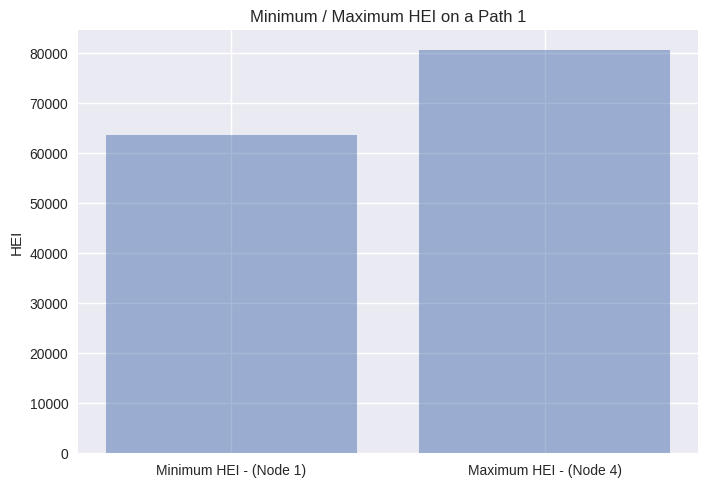

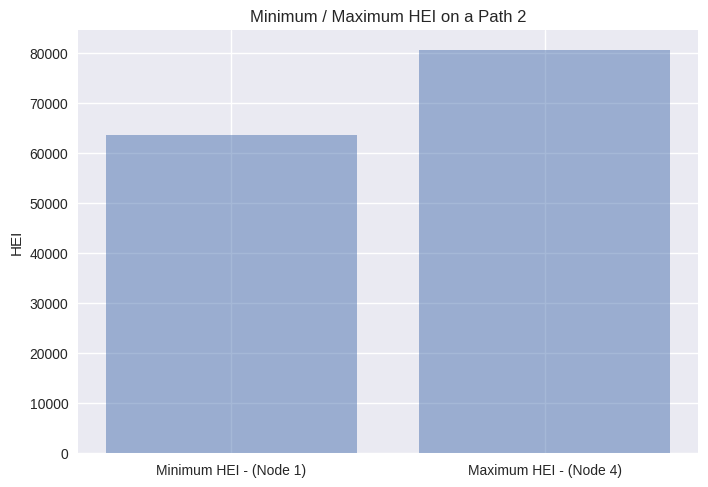

In [17]:
import numpy as np

def min_max_hei_on_path(host):
    PATH_ID = HOST_NAME_TO_PATH[host]
    min_packets = filter_packets_by_aggregate(get_all_packets(PATH_EXPORT_FILES[PATH_ID]), IOAM_MIN_AGGREGATE)
    max_packets = filter_packets_by_aggregate(get_all_packets(PATH_EXPORT_FILES[PATH_ID]), IOAM_MAX_AGGREGATE)

    min_hei_on_path = get_min_hei(min_packets)
    max_hei_on_path = get_min_hei(max_packets)

    paths = ('Minimum HEI - '  + '(Node ' + str(min_hei_on_path[1]) + ')', 'Maximum HEI - '  + '(Node ' + str(max_hei_on_path[1]) + ')')

    x_pos = np.arange(len(paths))
    performance = [min_hei_on_path[0], max_hei_on_path[0]]
    
    plt.bar(x_pos, performance, align='center', alpha=0.5)
    plt.xticks(x_pos, paths)
    plt.ylabel('HEI')
    plt.title('Minimum / Maximum HEI on a Path ' + str(HOST_NAME_TO_PATH[host]))
    plt.show()

for host in receiving_hosts:
    min_max_hei_on_path(host)

## Path Comparison
The graphic below shows that path 1 has a lower PEI value than path 2, which indicates that packets sent over path 1 are using the more efficient path.
The difference is fairly small because the energy mix values are all set to the same values on each node, but the idle power and embedded carbon parameter values vary.

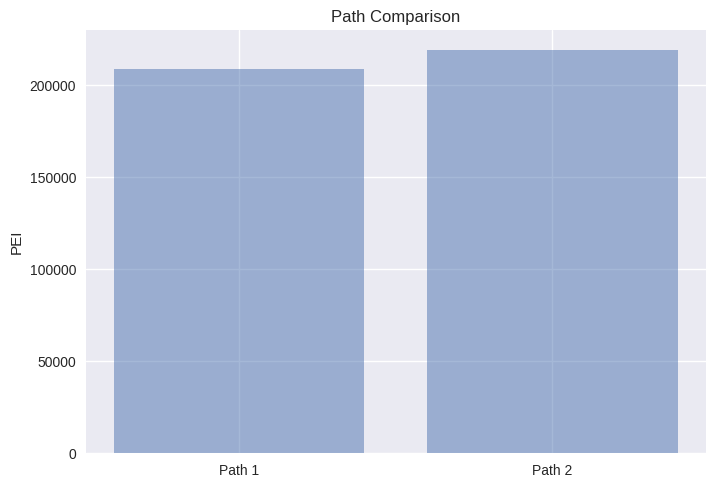

In [16]:
import numpy as np


def path_comparison(host1, host2):
    plot_data_host1, packets = get_plot_data(host1)
    plot_data_host2, packets = get_plot_data(host2)

    paths = ('Path ' + str(HOST_NAME_TO_PATH[host1]), 'Path ' + str(HOST_NAME_TO_PATH[host2]),)

    x_pos = np.arange(len(paths))
    performance = [plot_data_host1["aggregate"][-1], plot_data_host2["aggregate"][-1]]
    
    plt.bar(x_pos, performance, align='center', alpha=0.5)
    plt.xticks(x_pos, paths)
    plt.ylabel('PEI')
    plt.title('Path Comparison')

    plt.show()


path_comparison("h2", "h3")

## PEI Composition
The following diagram shows the composition of the PEI divided into the individual components which contributed to the PEI.

**NOTICE: The chart below contains extra information which is not contained in the IOAM data after aggregation.**

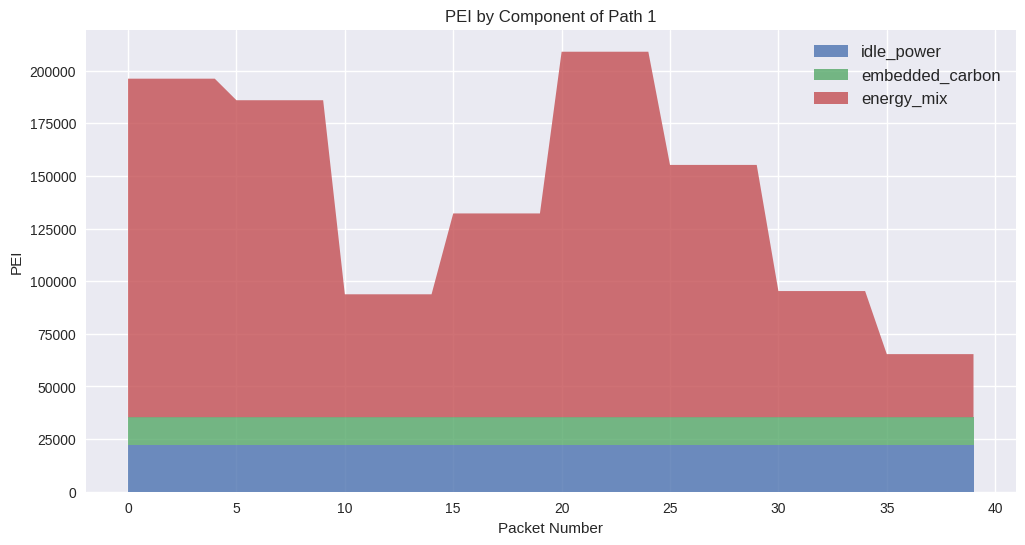

In [20]:
import os
import testing.utils
import testing.calc
import matplotlib.pyplot as plt



component_actions = {
    "MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix": {
        "value_bit_size": 7
    },
    "MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power": {
        "value_bit_size": 10
    },
    "MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon": {
        "value_bit_size": 16
    },
}

PATH_ID = 1

cases = os.path.join(BASE_DEMO_PATH, "cases.json")
paths = testing.utils.get_path_dict(cases)
packets = filter_packets_by_aggregate(get_all_packets(PATH_EXPORT_FILES[PATH_ID]), IOAM_SUM_AGGREGATE)

pei_by_component_plot_data = {
    "energy_mix": [],
    "idle_power": [],
    "embedded_carbon": []
}

for packet in packets:
    demo_runtime_dir = os.path.join(BASE_RUNTIME_PATH, packet["test_id"])
    node_component_data_list = testing.utils.get_nodes_component_data(paths[PATH_ID], component_actions, demo_runtime_dir)
    pei, pei_by_component = testing.calc.calculate_pei_by_component(paths[PATH_ID], node_component_data_list)
    for component_name, value in pei_by_component.items():
        pei_by_component_plot_data[component_name].append(value)


x = list(range(0,len(packets)))
fig, axes = plt.subplots(figsize=(12, 6))
axes.stackplot(x,
              [pei_by_component_plot_data['idle_power'],
               pei_by_component_plot_data['embedded_carbon'], pei_by_component_plot_data['energy_mix']],
              labels=['idle_power', 'embedded_carbon', 'energy_mix'],
              alpha=0.8)
axes.legend(loc="upper right", fontsize="large")
axes.set_title(f"PEI by Component of Path {PATH_ID}")
axes.set_xlabel("Packet Number")
axes.set_ylabel("PEI")
plt.show()

## Path Statistics
The demo case about the path statistics which fulfills the definition of UC06 shows the following information about the paths:
- Path Identification
- Timestamp of last update
- Hops traversed
- Number of packets received
- Amount of data received
- Latest PEI value
- Average PEI value
- MAX HEI value and corresponding node id
- MIN HEI value and corresponding node id

In [2]:
import datetime
import pandas as pd
from IPython.display import HTML, display


table_resources = []
path_entry = {
    "path_id": None,
    "timestamp": None,
    "node_list": None,
    "num_packets": None,
    "amount_data": None,
    "latest_pei": None,
    "average_pei": None,
    "max_hei": None,
    "min_hei": None,
}

def convert_timestamp(timestamp):
    timestamp_seconds = timestamp / 1e9
    dt_object = datetime.datetime.utcfromtimestamp(timestamp_seconds)
    # Format the datetime object as a string
    datetime_string = dt_object.strftime('%Y-%m-%d %H:%M:%S.%f')
    return datetime_string

def calc_total_data_amount(packets):
    data_amount_bytes = 0
    for packet in packets:
        data_amount_bytes += packet["size"]
    return data_amount_bytes

def calc_average_pei(packets):
    pei_sum = 0
    for packet in packets:
        pei_sum += packet["hop_by_hop_option"]["ioam_option_aggregation"]["aggregate"]
    return round(pei_sum / len(packets))

for path_id, export_file in PATH_EXPORT_FILES.items():
    entry = path_entry.copy()
    packets = get_all_packets(export_file)
    packets_sum = filter_packets_by_aggregate(packets, IOAM_SUM_AGGREGATE)
    packets_min = filter_packets_by_aggregate(packets, IOAM_MIN_AGGREGATE)
    packets_max = filter_packets_by_aggregate(packets, IOAM_MAX_AGGREGATE)

    entry['path_id'] = path_id
    entry['timestamp'] = convert_timestamp(packets[-1]['timestamp'])
    entry['node_list'] = packets[-1]["hop_by_hop_option"]["ioam_option_tracing"]["node_list"]
    entry['num_packets'] = len(packets)
    entry['amount_data'] = str(calc_total_data_amount(packets)) + " bytes"
    entry['latest_pei'] = packets_sum[-1]["hop_by_hop_option"]["ioam_option_aggregation"]["aggregate"]
    entry['average_pei'] = calc_average_pei(packets_sum)
    entry['min_hei'] = get_min_hei(packets_min)
    entry['max_hei'] = get_max_hei(packets_max)

    table_resources.append(entry)

df = pd.DataFrame(table_resources)
display(HTML(df.to_html()))


,path_id,timestamp,node_list,num_packets,amount_data,latest_pei,average_pei,max_hei,min_hei
0,1,2023-12-16 15:59:10.015020,"[{'hop_limit': 0, 'node_id': 0}, {'hop_limit': 59, 'node_id': 1}, {'hop_limit': 58, 'node_id': 2}, {'hop_limit': 57, 'node_id': 4}]",50,26340 bytes,65349,141603,"(80654, 4)","(63554, 1)"
1,2,2023-12-16 15:44:32.269356,"[{'hop_limit': 0, 'node_id': 0}, {'hop_limit': 59, 'node_id': 1}, {'hop_limit': 58, 'node_id': 3}, {'hop_limit': 57, 'node_id': 4}]",35,18438 bytes,219162,172570,"(80654, 4)","(63554, 1)"


## Sample step by step PEI calculation

This demo shows how the PEI is calculated given the id of the demo case.

In [19]:
from rich import print


DEMO_CASE_ID = "d15b0dd2-9b80-11ee-99de-0800270cf606"
PATH_ID = 1

component_actions = {
    "MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix": {
        "value_bit_size": 7
    },
    "MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power": {
        "value_bit_size": 10
    },
    "MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon": {
        "value_bit_size": 16
    },
}

cases = os.path.join(BASE_DEMO_PATH, "cases.json")
paths = testing.utils.get_path_dict(cases)
packets = filter_packets_by_aggregate(get_all_packets(PATH_EXPORT_FILES[PATH_ID]), IOAM_SUM_AGGREGATE)

pei_by_component_plot_data = {
    "energy_mix": [],
    "idle_power": [],
    "embedded_carbon": []
}


def do_verbose_pei_calculation(path, nodes_component_list):
    pei = 0
    print(f"Calculating PEI for path {path['id']} for demo case {DEMO_CASE_ID}")
    for node in nodes_component_list:
        hei = 0
        print(f"Calculating HEI for node [bold cyan]{node['name']}[/bold cyan]")
        print(f"The components and corresponding values of node [bold cyan]{node['name']}[/bold cyan] are:")
        print(node['components'])
        for component_name, components_params in node['components'].items():
            print(f"Calculating the component [bold yellow]{component_name}[/bold yellow]")
            print(f"Normalizing value {components_params['value']} with a bit length of {components_params['value_bit_size']} into the normalized range with a bit length of 15")
            value_normalized = testing.calc.normalize(components_params['value'], components_params['value_bit_size'])
            print(f"The normalized value is [bold light_green]{value_normalized}[/bold light_green]")
            value_inverted = value_normalized
            if components_params['inverse'] == 1:
                print(f"The component [bold yellow]{component_name}[/bold yellow] behaves inverse to the HEI so the value must be inverted")
                value_inverted = testing.calc.invert(value_normalized, components_params['inverse'])
                print(f"The inverted value is [bold light_green]{value_inverted}[/bold light_green]")
            else:
                print(f"The component [bold yellow]{component_name}[/bold yellow] does not need inversion")
            print(f"Weighting the value {value_inverted}")
            if components_params['weight'] == 2:
                print(f"The weight is set to 2 which means that the component is of high importance and the impact to the HEI will be doubled")
            elif components_params['weight'] == 1:
                print(f"The weight is set to 1 which means that the component is of medium importance and the impact to the HEI is not changed")
            elif components_params['weight'] == 0:
                print(f"The weight is set to 0 which means that the component is of low importance and the impact to the HEI is halved")
            value_weighted = testing.calc.weight(value_inverted, components_params['weight'])
            print(f"The weighted value is [bold light_green]{value_weighted}[/bold light_green]")
            print(f"Adding the weighted value [bold light_green]{value_weighted}[/bold light_green] to the HEI which is currently {hei}")
            hei += value_weighted
            print(f"The new HEI after adding the calculated component value is [bold light_green]{hei}[/bold light_green]")
            print(f"Done with the component calculation of [bold yellow]{component_name}[/bold yellow]")
        print(f"Done with the HEI calculation of node [bold cyan]{node['name']}[/bold cyan]")
        print(f"Adding the HEI of node [bold cyan]{node['name']}[/bold cyan] with the value [bold light_green]{hei}[/bold light_green] to the PEI which is currently {pei}")
        pei += hei
        print(f"The new PEI after adding the calculated HEI value is [bold light_green]{pei}[/bold light_green]")
    print(f"Done with the PEI calculation for path {path['id']} for demo case {DEMO_CASE_ID}")
    print(f"The PEI value is [bold light_green]{pei}[/bold light_green]")

for packet in packets:
    if packet["test_id"] != DEMO_CASE_ID:
        break
    demo_runtime_dir = os.path.join(BASE_RUNTIME_PATH, DEMO_CASE_ID)
    node_component_data_list = testing.utils.get_nodes_component_data(paths[PATH_ID], component_actions, demo_runtime_dir)
    pei, pei_by_component = testing.calc.calculate_pei_by_component(paths[PATH_ID], node_component_data_list)
    do_verbose_pei_calculation(paths[PATH_ID], node_component_data_list)
    break

Calculating PEI for path 1 for demo case d15b0dd2-9b80-11ee-99de-0800270cf606

Calculating HEI for node s1

The components and corresponding values of node s1 are:

{
    'MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix': {
        'value': 10,
        'weight': 2,
        'inverse': 1,
        'value_bit_size': 7
    },
    'MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power': {
        'value': 100,
        'weight': 1,
        'inverse': 0,
        'value_bit_size': 10
    },
    'MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon': {
        'value': 10000,
        'weight': 0,
        'inverse': 0,
        'value_bit_size': 16
    }
}

Calculating the component MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix

Normalizing value 10 with a bit length of 7 into the normalized range with a bit length of 15

The normalized value is 2560

The component MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix behaves inverse to the HEI so the 
value must be inverted

The inverted value is 30207

Weighting the value 30207

The weight is set to 2 which means that the component is of high importance and the impact to the HEI will be 
doubled

The weighted value is 60414

Adding the weighted value 60414 to the HEI which is currently 0

The new HEI after adding the calculated component value is 60414

Done with the component calculation of MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix

Calculating the component MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power

Normalizing value 100 with a bit length of 10 into the normalized range with a bit length of 15

The normalized value is 3200

The component MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power does not need inversion

Weighting the value 3200

The weight is set to 1 which means that the component is of medium importance and the impact to the HEI is not 
changed

The weighted value is 3200

Adding the weighted value 3200 to the HEI which is currently 60414

The new HEI after adding the calculated component value is 63614

Done with the component calculation of MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power

Calculating the component MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon

Normalizing value 10000 with a bit length of 16 into the normalized range with a bit length of 15

The normalized value is 5000

The component MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon does not need inversion

Weighting the value 5000

The weight is set to 0 which means that the component is of low importance and the impact to the HEI is halved

The weighted value is 2500

Adding the weighted value 2500 to the HEI which is currently 63614

The new HEI after adding the calculated component value is 66114

Done with the component calculation of MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon

Done with the HEI calculation of node s1

Adding the HEI of node s1 with the value 66114 to the PEI which is currently 0

The new PEI after adding the calculated HEI value is 66114

Calculating HEI for node s2

The components and corresponding values of node s2 are:

{
    'MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix': {
        'value': 20,
        'weight': 2,
        'inverse': 1,
        'value_bit_size': 7
    },
    'MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power': {
        'value': 200,
        'weight': 1,
        'inverse': 0,
        'value_bit_size': 10
    },
    'MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon': {
        'value': 2000,
        'weight': 0,
        'inverse': 0,
        'value_bit_size': 16
    }
}

Calculating the component MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix

Normalizing value 20 with a bit length of 7 into the normalized range with a bit length of 15

The normalized value is 5120

The component MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix behaves inverse to the HEI so the 
value must be inverted

The inverted value is 27647

Weighting the value 27647

The weight is set to 2 which means that the component is of high importance and the impact to the HEI will be 
doubled

The weighted value is 55294

Adding the weighted value 55294 to the HEI which is currently 0

The new HEI after adding the calculated component value is 55294

Done with the component calculation of MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix

Calculating the component MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power

Normalizing value 200 with a bit length of 10 into the normalized range with a bit length of 15

The normalized value is 6400

The component MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power does not need inversion

Weighting the value 6400

The weight is set to 1 which means that the component is of medium importance and the impact to the HEI is not 
changed

The weighted value is 6400

Adding the weighted value 6400 to the HEI which is currently 55294

The new HEI after adding the calculated component value is 61694

Done with the component calculation of MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power

Calculating the component MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon

Normalizing value 2000 with a bit length of 16 into the normalized range with a bit length of 15

The normalized value is 1000

The component MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon does not need inversion

Weighting the value 1000

The weight is set to 0 which means that the component is of low importance and the impact to the HEI is halved

The weighted value is 500

Adding the weighted value 500 to the HEI which is currently 61694

The new HEI after adding the calculated component value is 62194

Done with the component calculation of MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon

Done with the HEI calculation of node s2

Adding the HEI of node s2 with the value 62194 to the PEI which is currently 66114

The new PEI after adding the calculated HEI value is 128308

Calculating HEI for node s4

The components and corresponding values of node s4 are:

{
    'MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix': {
        'value': 40,
        'weight': 2,
        'inverse': 1,
        'value_bit_size': 7
    },
    'MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power': {
        'value': 400,
        'weight': 1,
        'inverse': 0,
        'value_bit_size': 10
    },
    'MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon': {
        'value': 40000,
        'weight': 0,
        'inverse': 0,
        'value_bit_size': 16
    }
}

Calculating the component MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix

Normalizing value 40 with a bit length of 7 into the normalized range with a bit length of 15

The normalized value is 10240

The component MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix behaves inverse to the HEI so the 
value must be inverted

The inverted value is 22527

Weighting the value 22527

The weight is set to 2 which means that the component is of high importance and the impact to the HEI will be 
doubled

The weighted value is 45054

Adding the weighted value 45054 to the HEI which is currently 0

The new HEI after adding the calculated component value is 45054

Done with the component calculation of MyEgress.process_efficiency_indicator.get_carbon_metric_energy_mix

Calculating the component MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power

Normalizing value 400 with a bit length of 10 into the normalized range with a bit length of 15

The normalized value is 12800

The component MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power does not need inversion

Weighting the value 12800

The weight is set to 1 which means that the component is of medium importance and the impact to the HEI is not 
changed

The weighted value is 12800

Adding the weighted value 12800 to the HEI which is currently 45054

The new HEI after adding the calculated component value is 57854

Done with the component calculation of MyEgress.process_efficiency_indicator.get_carbon_metric_idle_power

Calculating the component MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon

Normalizing value 40000 with a bit length of 16 into the normalized range with a bit length of 15

The normalized value is 20000

The component MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon does not need inversion

Weighting the value 20000

The weight is set to 0 which means that the component is of low importance and the impact to the HEI is halved

The weighted value is 10000

Adding the weighted value 10000 to the HEI which is currently 57854

The new HEI after adding the calculated component value is 67854

Done with the component calculation of MyEgress.process_efficiency_indicator.get_carbon_metric_embedded_carbon

Done with the HEI calculation of node s4

Adding the HEI of node s4 with the value 67854 to the PEI which is currently 128308

The new PEI after adding the calculated HEI value is 196162

Done with the PEI calculation for path 1 for demo case d15b0dd2-9b80-11ee-99de-0800270cf606

The PEI value is 196162